In [1]:
import time

from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import KNeighborsClassifier
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /home/atila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/atila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("./data/CrunchBase_data.csv")
# Change column names, to make it easier to work with
df.columns = [c.replace(' ', '_') for c in df.columns]
df.head(2)

/home/atila/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22,23,24,25,26,27,28,39,64,76,83,87,89,105,107,109,110,111,112,117) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed:_0 Organization_Name  \
0           0           Immunai   
1           1   Covered by SAGE   

                               Organization_Name_URL  \
0    https://www.crunchbase.com/organization/immunai   
1  https://www.crunchbase.com/organization/sage-fb80   

                                          Industries  \
0  Artificial Intelligence, Biotechnology, Inform...   
1  Financial Services, Information Technology, In...   

                                         Description  \
0  Immunai is a biotech company that combines sin...   
1  Covered by SAGE is a modern insurance platform...   

                                    Full_Description  \
0  Immunai's mission is to map the entire immune ...   
1  Covered by SAGE is a technology-driven insuran...   

               Headquarters_Location  \
0  New York, New York, United States   
1  New York, New York, United States   

                                Headquarters_Regions Estimated_Revenue_Range  \
0  Greater New York Area, East Coast, Northeaster...                     NaN   
1  Greater New York Area, East Coast, Northeaster...             $1M to $10M   

  Operating_Status  ... Aberdeen_-_IT_Spend_Currency_(in_USD) Unnamed:_109  \
0           Active  ...                                   NaN          NaN   
1           Active  ...                                   NaN          NaN   

  Unnamed:_110 Unnamed:_111 Unnamed:_112 Unnamed:_113 Unnamed:_114  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   

  Unnamed:_115 Unnamed:_116 Unnamed:_117  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  

[2 rows x 119 columns]

In [3]:
df = df[["Organization_Name", "Full_Description"]]
df.drop_duplicates(subset ="Organization_Name", keep = 'last', inplace = True) 
df.dropna(inplace=True)
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101116 entries, 6 to 144620
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Organization_Name  101116 non-null  object
 1   Full_Description   101116 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [4]:
df.shape

(101116, 2)

In [5]:
df.head()

Organization_Name                                   Full_Description
6        Oh My Green  Ohmygreen is a health food company that delive...
10            eVisit  eVisit is a web application that connects prim...
13         Slingshot  Over the past two decades, we’ve witnessed a r...
14           DeFiner  DeFiner operates as a peer to peer fintech net...
15     Spectro Cloud  Spectro Cloud is an infrastructure company tha...

##  Prepraring Data

In [6]:
wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stopwords = set(stopwords.words('english'))

In [7]:
df = df[:5000].reset_index(drop=True)
df.shape

(5000, 2)

In [8]:
def clean_text(text):
    text = text.replace("\n", " ")
    # split string into words (tokens)
    tokens = nltk.tokenize.word_tokenize(text)
    # removing upper case strings
    tokens = [t for t in tokens if t.islower()]
    # keep strings with only alphabets
    tokens = [t for t in tokens if t.isalpha()]
    # put words into base form
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] 
    tokens = [stemmer.stem(t) for t in tokens]
    # remove short words, they're probably not useful
    tokens = [t for t in tokens if len(t) > 2]
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    cleanedText = " ".join(tokens)
    return cleanedText

In [9]:
X = df.reset_index(drop=True).Full_Description
text = X.values
X = X.apply(clean_text)
X

0       health food compani deliv food directli compan...
1       web applic connect primari care provid patient...
2       past two decad wit revolut custom expect behav...
3       oper peer peer fintech network digit asset sav...
4       infrastructur compani provid scalabl cluster m...
                              ...                        
4995    app learn write charact choos vocabulari list ...
4996    longer longer time arriv world come togeth equ...
4997    build deep learn processor architectur clean r...
4998    build easiest intuit tool financi advisor cons...
4999    broken enterpris effect way get good relev val...
Name: Full_Description, Length: 5000, dtype: object

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), norm='l2')
X_tfidf = vectorizer.fit_transform(X)
X_tfidf

<5000x133586 sparse matrix of type '<class 'numpy.float64'>'
	with 337916 stored elements in Compressed Sparse Row format>

In [11]:
feature_names = vectorizer.get_feature_names()
feature_names

['aand',
 'aand receiv',
 'aapi',
 'aapi app',
 'aapi simpli',
 'aapi turn',
 'abdomen',
 'abdomin',
 'abdomin separ',
 'aberr',
 'aberr behavior',
 'abid',
 'abid set',
 'abil',
 'abil accept',
 'abil access',
 'abil accumul',
 'abil across',
 'abil add',
 'abil analyz',
 'abil appoint',
 'abil ass',
 'abil autom',
 'abil automat',
 'abil automot',
 'abil brand',
 'abil build',
 'abil candid',
 'abil categoris',
 'abil chang',
 'abil come',
 'abil commun',
 'abil compani',
 'abil compar',
 'abil compet',
 'abil connect',
 'abil consist',
 'abil consum',
 'abil control',
 'abil cope',
 'abil creat',
 'abil cross',
 'abil deep',
 'abil defin',
 'abil deliv',
 'abil digest',
 'abil discov',
 'abil display',
 'abil distribut',
 'abil drive',
 'abil earn',
 'abil easili',
 'abil effortlessli',
 'abil film',
 'abil gather',
 'abil grow',
 'abil hail',
 'abil human',
 'abil identifi',
 'abil improv',
 'abil influenc',
 'abil know',
 'abil languag',
 'abil launch',
 'abil learn',
 'abil learn

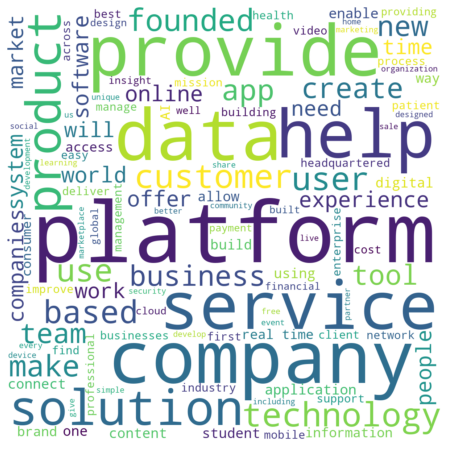

In [12]:
# Create and generate a word cloud image
plt.figure(figsize=(8,8))
wordcloud = WordCloud(height=1200, width=1200, background_color='white',min_font_size=20).generate(" ".join(text))
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0, 0.5, 'words')

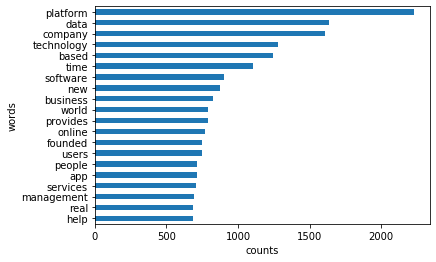

In [13]:
# Token (vocabulary) Frequency Distribution After Removing Stop Words
def get_top_n_words_without_stopwords(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_nostopwords = get_top_n_words_without_stopwords(df['Full_Description'], 20)
df_topwords_nostopwords = pd.DataFrame(common_words_nostopwords, columns = ['Description' , 'Count'])
ax = df_topwords_nostopwords.groupby('Description').sum()['Count'].sort_values().plot(kind='barh')
ax.set_xlabel('counts')
ax.set_ylabel('words')

## Keyword detection

In [14]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    items =  sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
    result = [x[0] for x in items]
    return result 

def extract_topn_keywords(feature_names, sorted_items, topn=10):
    sorted_items = sorted_items[:2*topn]
    words = []
    new_words = []
    
    # word index and corresponding tf-idf scores
    for idx in sorted_items:
        words.append(feature_names[idx])
        if len(feature_names[idx].split())>1:
            new_words.append(feature_names[idx])
         
    for i in range(len(words)):
        k = True
        for j in range(len(new_words)):         
            if (new_words[j].find(words[i]) != -1):
                k = False
        if k:
            new_words.append(words[i])
    keywords = list(OrderedDict.fromkeys(new_words))[:topn]
    return keywords

In [15]:
doc = df.loc[0].Full_Description
start = time.time()

tf_idf_vector = vectorizer.transform([doc])  ## vectorizing text
sorted_items = sort_coo(tf_idf_vector.tocoo())  ## sorting elements(weights) from vector
keywords = extract_topn_keywords(feature_names, sorted_items, topn=20)  ## finding words with those weights(keywords)
end = time.time()
keywords, end-start

(['rest detox',
  'make healthier',
  'healthier smarter',
  'health food',
  'gluten free',
  'one stop',
  'data driven',
  'empower',
  'garden',
  'bliss',
  'vegan',
  'green',
  'non',
  'took',
  'youth',
  'eat',
  'budget',
  'heart',
  'would',
  'three'],
 0.0045812129974365234)

## Competitors Similarities

In [16]:
Full_Description_Series = pd.Series(df['Organization_Name'])
inddict = Full_Description_Series.to_dict()
inddict = dict((v,k) for k,v in inddict.items())
inddict

{'Oh My Green': 0,
 'eVisit': 1,
 'Slingshot': 2,
 'DeFiner': 3,
 'Spectro Cloud': 4,
 'Synapse Technology Corporation': 5,
 'Databook': 6,
 'Bonusly': 7,
 'Codementor': 8,
 'Flockjay': 9,
 '2ndKitchen': 10,
 'Omnia Fishing': 11,
 'FairShake': 12,
 'Digi-Prex': 13,
 'SIMBA Chain': 14,
 'Raydiant': 15,
 'Expo': 16,
 'Orum': 17,
 'CHAMPtitles': 18,
 'Crosschq': 19,
 'Kinside': 20,
 'Hwy Haul': 21,
 'Squadcast': 22,
 'Brella': 23,
 'Slintel': 24,
 'Projector': 25,
 'Censia': 26,
 'AuthorDigital': 27,
 'Formant': 28,
 'Rivery.io': 29,
 'Flume Health': 30,
 'Moving Analytics': 31,
 'TrueCare24': 32,
 'Fluree': 33,
 'Fuzzbuzz': 34,
 'genneve': 35,
 'Jetson': 36,
 'SimpleCitizen': 37,
 'Wootcloud': 38,
 'SyncFab': 39,
 'Doctible': 40,
 'CARFIT': 41,
 'Sigma Ratings': 42,
 'TFLiving': 43,
 'Lexion': 44,
 'Stories': 45,
 'Battlecard': 46,
 'Medcurity': 47,
 'Insurdata': 48,
 'Dasha.AI': 49,
 'Sequr': 50,
 'Elementus': 51,
 'eyecandylab': 52,
 'DroneUp': 53,
 'Bloomer Health Tech': 54,
 'Dyneti 

In [17]:
def similar_companies(description, topn=10):
    tf_idf_ex = vectorizer.transform([clean_text(description)])
    cosine_sim = linear_kernel(X_tfidf, tf_idf_ex)
    similarity_scores = list(enumerate(cosine_sim))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:topn+1]
    organization_index = [i[0] for i in similarity_scores]
    # Return the top 10 most similar organizations 
    return df.iloc[organization_index]


In [18]:
description_ex = df.loc[0].Full_Description
print("Original comapany description: ", description_ex)
similar_companies(description_ex, topn=10)

Original comapany description:  Ohmygreen is a health food company that delivers food directly to a company’s doors. Offering healthy office snacks including vegan, gluten-free, organic and non-GMO options, the company aims to empower the workplace and lead people to make healthier, smarter choices across nutrition, exercise, rest, detox and overall wellbeing. Ohmygreen offers a one stop shopping experience that incorporates budget management, office stocking and food delivery. There are three services to choose from when signing up: Zen, Bliss or Nirvana. Each of these services is data driven and food focused while every service is customized to meet the needs of the client. The company's mission is to empower people to live healthy and blissful lives.  Founder Michael Heinrich was inspired in his youth in Berlin, Germany where his Grandmother cultivated an organic garden and served hearty home-cooked meals. As a medical doctor she would emphasize that if you want to stay healthy eat 

Organization_Name                                   Full_Description
2777           100Nuts  100Nuts is an A.I.-powered food market disrupt...
3681          OrderOut  OrderOut integrates food delivery platforms, s...
4261             Copia  Every day in America, they waste 3X more food ...
2515          Kafoodle  Kafoodle is an award-winning food tech company...
1445           Chowbus  Chowbus, Inc. develops an online authentic foo...
2428           Piccolo  Piccolo, is shaking up the baby food world wit...
3864     Approved Food  Approved Food is an online seller of clearance...
1919              Edyn  The Edyn smart garden system lets you know wha...
3615           Wellory  Wellory is on a mission is to make healthy eat...
696               Z2AI                      Z2AI is a Technology company.

In [19]:
print("Most similar company descriptions:")
similar_companies(description_ex, topn=10).Full_Description.values

Most similar company descriptions:


array(['100Nuts is an A.I.-powered food market disruptor that bridges both food and health technology. It is an app for food consumers, which brings a radical solution to the complexity of choosing the right food.  It is a food-centric search engine and navigation system which processes vast dataset (food, nutrition, and user data) to create the perfect diet for the user. It is also a platform for food suppliers, such as producers, retailers, online food delivery platforms, restaurants, which empowers them to engage with individual consumers at the optimal time with a product offer matching their exact dietary needs.',
       'OrderOut integrates food delivery platforms, such as UberEats, DoorDash and Postmates, directly to a restaurant’s Point of Sale (POS).  OrderOut also provides a virtual data and analytics dashboard, so that restaurants can see what food delivery services and food items are performing best and when.',
       "Every day in America, they waste 3X more food than ther